# Demo: guided proposal for cell differentiation and development model

In [43]:
import DiffusionBridge as db
import torch
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from DiffusionBridge.utils import normal_logpdf
plt.style.use("ggplot")

In [51]:
# problem settings
d = 2
T = torch.tensor(2.0)

# parameters
alpha = torch.tensor(1.0)
beta = torch.tensor(1.0)
kappa = torch.tensor(1.0)
p = torch.tensor(4.0)
xi = torch.tensor(0.5)


# drift
def drift(x):
    out = torch.zeros(x.shape)
    out[:, 0] = (
        alpha * x[:, 0] ** p / (xi**p + x[:, 0] ** p)
        + beta * xi**p / (xi**p + x[:, 1] ** p)
        - kappa * x[:, 0]
    )
    out[:, 1] = (
        alpha * x[:, 1] ** p / (xi**p + x[:, 1] ** p)
        + beta * xi**p / (xi**p + x[:, 0] ** p)
        - kappa * x[:, 1]
    )
    return out


f = lambda t, x: drift(x)

# diffusion coefficient
sigma = torch.tensor(1.0)
# sigma = torch.sqrt(torch.tensor(1 * 1e-1))
print("Diffusion coefficient: " + str(sigma))

# number of time-discretization steps
M = 100

# initialize diffusion model
diffusion = db.diffusion.model(f, sigma, d, T, M)

Diffusion coefficient: tensor(1.)


In [52]:
# drift to find fixed points
def drift_(x):
    out = torch.zeros(d)
    out[0] = (
        alpha * x[0] ** p / (xi**p + x[0] ** p)
        + beta * xi**p / (xi**p + x[1] ** p)
        - kappa * x[0]
    )
    out[1] = (
        alpha * x[1] ** p / (xi**p + x[1] ** p)
        + beta * xi**p / (xi**p + x[0] ** p)
        - kappa * x[1]
    )
    return out


# undifferentiated cell state
X0 = torch.ones(d)
print(drift_(X0))
print("Undifferentiated cell state: " + str(X0))

# differentiate cell state
XT = torch.tensor(fsolve(func=drift_, x0=torch.tensor([0.0, 2.0])), dtype=torch.float32)
print(drift_(XT))
print("Differentiated cell state: " + str(XT))

tensor([0., 0.])
Undifferentiated cell state: tensor([1., 1.])
tensor([0., 0.])
Differentiated cell state: tensor([0.0039, 1.9961])


# Backward diffusion bridge with score matching

In [53]:
# learn backward diffusion bridge process with score matching
epsilon = 1.0
minibatch = 100
num_iterations = 1000
learning_rate = 0.01
ema_momentum = 0.99
output = diffusion.learn_score_transition(
    X0, XT, epsilon, minibatch, num_iterations, learning_rate, ema_momentum
)
score_transition_net = output["net"]
loss_values_transition = output["loss"]

Optimization iteration: 1 Loss: 47.64122009277344
Optimization iteration: 50 Loss: 46.18828582763672
Optimization iteration: 100 Loss: 47.5106086730957
Optimization iteration: 150 Loss: 46.09600830078125
Optimization iteration: 200 Loss: 46.069053649902344
Optimization iteration: 250 Loss: 46.14701461791992
Optimization iteration: 300 Loss: 46.162410736083984
Optimization iteration: 350 Loss: 46.62836837768555
Optimization iteration: 400 Loss: 47.53986358642578
Optimization iteration: 450 Loss: 46.58108139038086
Optimization iteration: 500 Loss: 45.884498596191406
Optimization iteration: 550 Loss: 46.99983215332031
Optimization iteration: 600 Loss: 46.945098876953125
Optimization iteration: 650 Loss: 45.99186325073242
Optimization iteration: 700 Loss: 45.82754135131836
Optimization iteration: 750 Loss: 46.558990478515625
Optimization iteration: 800 Loss: 46.2984504699707
Optimization iteration: 850 Loss: 47.469905853271484
Optimization iteration: 900 Loss: 46.66142272949219
Optimizatio

log-transition density: -2.1066362857818604
ESS%: 92.25357055664062
Acceptance rate: 0.83984375


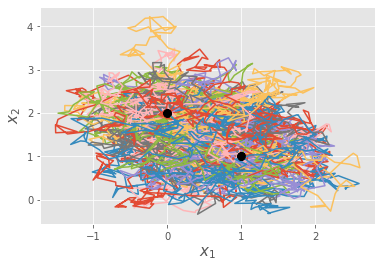

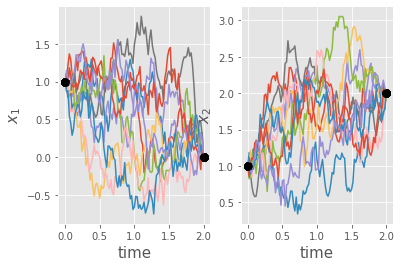

In [56]:
# simulate diffusion bridge process backwards using approximate score
epsilon = 1.0
N = 2**10
with torch.no_grad():
    output = diffusion.simulate_bridge_backwards(
        score_transition_net, X0, XT, epsilon, N, modify=True
    )
    trajectories = output["trajectories"]
    log_proposal = output["logdensity"]

# importance sampling
log_target = diffusion.law_bridge(trajectories)
log_weights = log_target - log_proposal
max_log_weights = torch.max(log_weights)
weights = torch.exp(log_weights - max_log_weights)
norm_weights = weights / torch.sum(weights)
ess = 1.0 / torch.sum(norm_weights**2)
log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
print("log-transition density: " + str(float(log_transition_estimate)))
print("ESS%: " + str(float(ess * 100 / N)))

# independent Metropolis-Hastings
initial = diffusion.simulate_bridge_backwards(
    score_transition_net, X0, XT, epsilon, 1, modify=True
)
current_trajectory = initial["trajectories"]
current_log_proposal = initial["logdensity"]
current_log_target = diffusion.law_bridge(current_trajectory)
current_log_weight = current_log_target - current_log_proposal
num_accept = 0
for n in range(N):
    proposed_trajectory = trajectories[n, :, :]
    proposed_log_weight = log_weights[n]
    log_accept_prob = proposed_log_weight - current_log_weight

    if torch.log(torch.rand(1)) < log_accept_prob:
        current_trajectory = proposed_trajectory.clone()
        current_log_weight = proposed_log_weight.clone()
        num_accept += 1
accept_rate = num_accept / N
print("Acceptance rate: " + str(float(accept_rate)))

# plot some trajectories
plt.figure()
for n in range(100):
    plt.plot(trajectories[n, :, 0], trajectories[n, :, 1])
    plt.plot(X0[0], X0[1], "k.", markersize=15)
    plt.plot(XT[0], XT[1], "k.", markersize=15)
    plt.xlabel("time", fontsize=15)
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15)

plt.figure()
plt.subplot(1, 2, 1)
for n in range(10):
    plt.plot(diffusion.time, trajectories[n, :, 0])
    plt.plot([0.0, T], [X0[0], XT[0]], "k.", markersize=15)
    plt.xlabel("time", fontsize=15)
    plt.ylabel("$x_1$", fontsize=15)

plt.subplot(1, 2, 2)
for n in range(10):
    plt.plot(diffusion.time, trajectories[n, :, 1])
    plt.plot([0.0, T], [X0[1], XT[1]], "k.", markersize=15)
    plt.xlabel("time", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15)

# Guided proposal process

In [4]:
auxiliary_type = "ou"
# auxiliary_type = "brownian"
initial_params = {
    "alpha": 1.0 * torch.randn(d),
    "beta": 1.0 * torch.randn(d),
}
niter = 1000

output = diffusion.learn_guided_proposal(
    auxiliary_type,
    initial_params,
    initial_state=X0,
    terminal_state=XT,
    minibatch=100,
    num_iterations=niter,
    learning_rate=0.01,
)

/Users/jeremy/Library/CloudStorage/Dropbox/DiffusionBridge/DiffusionBridge/DiffusionBridge/auxiliary.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  name: torch.tensor(value, requires_grad=True)


Optimization iteration: 1 Loss: -42.09661102294922
Optimization iteration: 50 Loss: -1.8520207405090332
Optimization iteration: 100 Loss: -2.6221923828125
Optimization iteration: 150 Loss: -2.985337018966675
Optimization iteration: 200 Loss: -3.153191328048706
Optimization iteration: 250 Loss: -3.293733835220337
Optimization iteration: 300 Loss: -3.007207155227661
Optimization iteration: 350 Loss: -3.2498631477355957
Optimization iteration: 400 Loss: -3.1031041145324707
Optimization iteration: 450 Loss: -3.0059516429901123
Optimization iteration: 500 Loss: -3.124049186706543
Optimization iteration: 550 Loss: -3.271932601928711
Optimization iteration: 600 Loss: -3.0444393157958984
Optimization iteration: 650 Loss: -3.283552646636963
Optimization iteration: 700 Loss: -3.2816197872161865
Optimization iteration: 750 Loss: -3.1329894065856934
Optimization iteration: 800 Loss: -3.1190261840820312
Optimization iteration: 850 Loss: -3.0602731704711914
Optimization iteration: 900 Loss: -3.09002

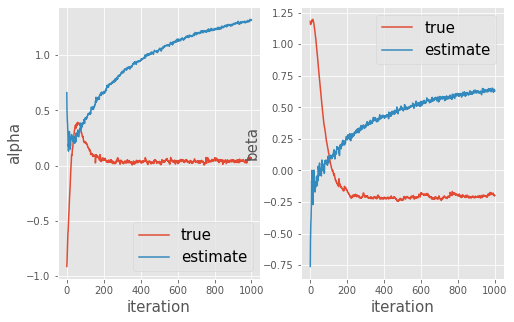

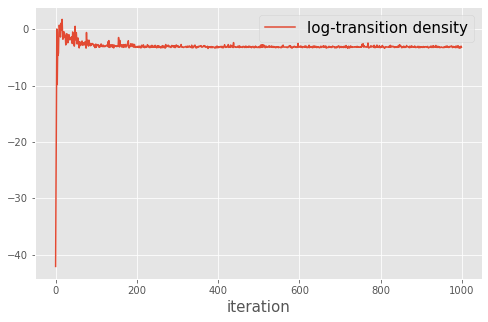

In [5]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
# plt.hlines(float(alpha), 0, niter, color="black")
plt.plot(output["params"]["alpha"])
plt.xlabel("iteration", fontsize=15)
plt.ylabel("alpha", fontsize=15)
plt.legend(["true", "estimate"], fontsize=15)

plt.subplot(1, 2, 2)
# plt.hlines(float(beta), 0, niter, color="black")
plt.plot(output["params"]["beta"])
plt.xlabel("iteration", fontsize=15)
plt.ylabel("beta", fontsize=15)
plt.legend(["true", "estimate"], fontsize=15)

plt.figure(figsize=(8, 5))
# plt.hlines(float(log_transition_density(T, XT, X0)), 0, niter, color="black")
plt.plot(output["loss"].detach().numpy())
plt.xlabel("iteration", fontsize=15)
plt.legend(["log-transition density", "loss"], fontsize=15)

In [41]:
N = 2**10
proposal_drift = lambda t, x: diffusion.f(t, x) + diffusion.Sigma * output[
    "auxiliary"
].grad_logh(XT, t, x)
with torch.no_grad():
    simulation_output = diffusion.simulate_proposal_bridge(
        proposal_drift, X0, XT, N, modify=False
    )
    trajectories = simulation_output["trajectories"]
    log_proposal = simulation_output["logdensity"]
# log_target = diffusion.law_bridge(trajectories)
# log_weights = log_target - log_proposal
log_weights = output["auxiliary"].log_radon_nikodym(trajectories)

# importance sampling
max_log_weights = torch.max(log_weights)
weights = torch.exp(log_weights - max_log_weights)
norm_weights = weights / torch.sum(weights)
ess = 1.0 / torch.sum(norm_weights**2)
log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
# print("log-transition density:", float(log_transition_density(T, XT, X0)))
print("IS log-transition estimate:", float(log_transition_estimate))
print("ESS%:", float(ess * 100 / N))

# independent Metropolis-Hastings
with torch.no_grad():
    initial = diffusion.simulate_proposal_bridge(proposal_drift, X0, XT, 1)
    current_trajectory = initial["trajectories"]
    current_log_proposal = initial["logdensity"]
current_log_target = diffusion.law_bridge(current_trajectory)
current_log_weight = current_log_target - current_log_proposal
num_accept = 0
for n in range(N):
    proposed_trajectory = trajectories[n, :, :]
    proposed_log_weight = log_weights[n]
    log_accept_prob = proposed_log_weight - current_log_weight

    if torch.log(torch.rand(1)) < log_accept_prob:
        current_trajectory = proposed_trajectory.clone()
        current_log_weight = proposed_log_weight.clone()
        num_accept += 1
accept_rate = num_accept / N
print("IMH acceptance rate:", accept_rate)

IS log-transition estimate: -3.3290252685546875
ESS%: 67.79013061523438
IMH acceptance rate: 0.6494140625
